In [1]:
# Deep Dream using InceptionV3

import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from scipy.ndimage import zoom
from keras.applications import inception_v3
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import save_img
from tensorflow.python.framework.ops import disable_eager_execution

K.set_learning_phase(False)
disable_eager_execution()

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [2]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
# model.summary()

In [3]:
layer_contribution = {'mixed2': 0.4,
                      'mixed3': 2.0,
                      'mixed4': 1.5,
                      'mixed5': 2.3,
                      }
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [4]:
loss = K.variable(0.0)

for layer_name in layer_contribution:
    coeff = layer_contribution[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # Ignoring the border pixels values
    loss = loss + coeff * (K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling)

dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]

fetch_loss_and_grads = K.function([dream], outputs)

In [5]:
def preprocess_img(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return zoom(img, factors, order=1)

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += (step * grad_values)
    return x

In [6]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10

In [7]:
base_image_path = './input.jpg'
img = preprocess_img(base_image_path)
original_shape = img.shape[1:3]

successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)

shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)

    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations=iterations, step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

    temp_img = deprocess_image(np.copy(img))
    save_img('deepdream_output/dream_at_scale_'+str(shape)+'.png', temp_img)

final_img = deprocess_image(np.copy(img))
save_img('final_dream.png', final_img)
print('Finished!!!')

Processing image shape (93, 140)
...Loss value at 0 : 0.086179875
...Loss value at 1 : 0.1013003
...Loss value at 2 : 0.12514186
...Loss value at 3 : 0.14750144
...Loss value at 4 : 0.1662821
...Loss value at 5 : 0.18666004
...Loss value at 6 : 0.20387928
...Loss value at 7 : 0.22148137
...Loss value at 8 : 0.24006431
...Loss value at 9 : 0.25929013
...Loss value at 10 : 0.2746875
...Loss value at 11 : 0.28957108
...Loss value at 12 : 0.30451113
...Loss value at 13 : 0.3201978
...Loss value at 14 : 0.33837107
...Loss value at 15 : 0.3524172
...Loss value at 16 : 0.36858627
...Loss value at 17 : 0.38192758
...Loss value at 18 : 0.39588884
...Loss value at 19 : 0.41107932
Processing image shape (130, 196)
...Loss value at 0 : 0.9222852
...Loss value at 1 : 1.4073348
...Loss value at 2 : 1.892062
...Loss value at 3 : 2.3385158
...Loss value at 4 : 2.7037113
...Loss value at 5 : 3.0375729
...Loss value at 6 : 3.3460019
...Loss value at 7 : 3.6589363
...Loss value at 8 : 4.0304804
...Loss v

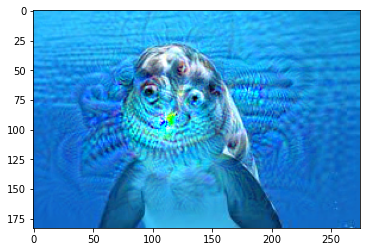

In [8]:
img = imread('./final_dream.png')
plt.imshow(img)
plt.show()